<a href="https://colab.research.google.com/github/noah-beniteznelson/recharge_deficit/blob/main/recharge_ratio_resolution_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- [![DOI](https://zenodo.org/badge/357586333.svg)](https://zenodo.org/badge/latestdoi/357586333) -->

Change DOI HERE

#**How does increasing the temporal resolution of the data (from daily to hourly) affect the observed deficit-recharge relationship?**

---

Use data from Angelo rain-bucket, limit analysis from 2016-2020 for equivalent
comparison (only range where data overlaps).

---
Created for *Patterns of Intra-Seasonal Groundwater Recharge Inferred from Streamflow and Explained by Vadose Zone Storage Deficits*.

**Load packages.**

In [ ]:
!pip install -q geopandas
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import scipy
import os
import warnings
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
%config InlineBackend.figure_format = 'retina'

**Mount Google Drive.** For running analyses in GoogleColab, save and  import datasets to/from selected folder in Google Drive.  To mount Drive, find the file name of the folder you wish to connect to.  By default, files are saved to user's "My Drive" dashboard.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)  # Change folder name here

Mounted at /content/drive


**Extract daily discharge (USGS).**

In [ ]:
def getFlow(gage, start_date, end_date):
  """
  Retrieves daily discharge measured by U.S. Geological Survey (USGS) gage
  stations from the National Water Information System between selected dates.
  @params:
    gage (:obj:`str`): USGS 8-number gage station ID
    start_date (:obj:`str`): Start of data retrieval (format: 'yyyy-mm-dd')
    end_date (:obj:`str`): End of data retrieval (format: 'yyyy-mm-dd')
  @returns:
    df (:obj:`df`):    Discharge (mm/day)
  """
  # Read streamflow data and clean csv
  url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=%s&referred_module=sw&period=&begin_date=%s&end_date=%s'%(gage, start_date, end_date)
  df = pd.read_csv(url, header=31, delim_whitespace=True)
  df.columns = ['usgs', 'site_number', 'datetime', 'Q_cfs', 'a']
  df.index = pd.to_datetime(df.datetime)
  basin = gp.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%gage)
  try:
    geoms = [item for item in list(basin.geometry[0])]
    idx = np.argmax([item.area for item in geoms])
    basin.geometry = [geoms[idx]]
    print('Found multipolygon - fixing')
  except:
    basin.geometry = basin.geometry
  area_mm2 = basin.to_crs('epsg:26910').geometry[0].area*1e6
  df['Q_mm'] = 2.44657555e12*df[['Q_cfs']]/area_mm2 # Flow in mm/day
  df = df[['Q_mm']].astype(float, errors='ignore')
  df.columns = ['USGS_Q_mm']
  return df

# Extract flow at Elder Creek (USGS Gage ID: 11475560)
df_daily_flow = getFlow("11475560",'2000-09-01','2023-11-01')

**Extract hourly discharge (USGS).**

In [ ]:
# Extract streamflow at 15-minute resolution
def getFlow_15min(site,start,stop):
  """
  Extract 15-minute discharge from USGS National Water Information Service,
  convert to length scale (mm/day) using catchment geometry.
  """
  url="https://nwis.waterservices.usgs.gov/nwis/iv/?format=rdb&sites="+site+"&startDT="+start+"T00:00%2b0700&endDT="+stop+"T08:00%2b0000&parameterCd=00060&siteType=ST&siteStatus=all"
  print(url)
  df = pd.read_csv(url,header=40,delim_whitespace=True)
  df.columns = ['source','site', 'date', 'time', 'timezone', 'q', 'a']
  df.index = pd.to_datetime(df.date+' '+df.time)
  basin = gp.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%site)
  try:
    geoms = [item for item in list(basin.geometry[0])]
    idx = np.argmax([item.area for item in geoms])
    basin.geometry = [geoms[idx]]
    print('Found multipolygon - fixing')
  except:
    basin.geometry = basin.geometry
  area_mm2 = basin.to_crs('epsg:26910').geometry[0].area*1000**2
  df = 2.44657555e12*df[['q']]/area_mm2
  df = df.loc[start:stop]
  df.q = df.q.astype(float, errors='ignore')
  return df

# Extract flow at Elder Creek (USGS Gage ID: 11475560)
df_15min_flow = getFlow_15min(site="11475560",start="2000-09-01",stop="2023-11-01")

# Upscale to hourly timeseries
df_hourly_flow = df_15min_flow.resample('1H').mean()/24 # 1 day/24 hours

https://nwis.waterservices.usgs.gov/nwis/iv/?format=rdb&sites=11475560&startDT=2000-09-01T00:00%2b0700&endDT=2023-11-01T08:00%2b0000&parameterCd=00060&siteType=ST&siteStatus=all


**Load hourly precipitation.**  Use Angelo tipping bucket data (Dralle et al., 2023).

In [ ]:
# Read in weather data from a CSV file and resample the rainfall data to daily sums
weather = pd.read_csv('https://hydroeco.github.io/angelo/angelo_weather_1H.csv', parse_dates=True, index_col=0)
df_hourly_rain = weather['AngeloMeadowWs_Rainfall_TB4'] #2015-2023 data range
df_hourly_rain = df_hourly_rain.loc['2016-10-01':'2020-10-01']

**Import daily deficit & linearly interpolate to hourly.**

In [ ]:
# Interpolate to daily and save deficit to new DataFrame
path = "/content/drive/My Drive/Research/recharge_deficit/data/"

# Catchment data
df_gages = pd.read_csv(path + "filtered_catchment_data.csv")
df_gages.set_index('Unnamed: 0',inplace=True,drop=True)
df_gages.index=pd.to_datetime(df_gages.index)
df_gages = df_gages.loc['2000-10-01':'2020-10-01']

# Extract Elder Creek gage data
gage = '11475560'
df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']])
df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
df_gage.set_index('date', inplace=True)
df_gage.index = pd.to_datetime(df_gage.index)

# Interpolate to hourly
df_hourly_gage = df_gage.resample('1H').interpolate("linear")
df_hourly_deficit = df_hourly_gage.D

**Combine & filter DataFrame, removing days with incomplete fluxes.**


In [ ]:
# Combine DataFrame
df_hourly_flow_rain_deficit = df_hourly_flow.join(df_hourly_rain).join(df_hourly_deficit)
df_hourly_flow_rain_deficit.rename(columns={"AngeloMeadowWs_Rainfall_TB4": "ppt"},inplace=True)

# Remove days with incomplete hydrologic fluxes
df_cleaned_hourly_flow_rain_deficit = df_hourly_flow_rain_deficit.dropna()

**Define sensitivity function.**  Following Wlostowski et al. (2021).

In [ ]:
# Kirchner (2009) binning function
def KirchnerBinning(df, binning, min_per_bin=10, loud=False):
  df = df.sort_values('q',ascending=False)
  logQ = np.array(np.log(df.q))
  logRange = np.max(logQ) - np.min(logQ)
  minBinSize = logRange*.01
  binBoundaries = [0]
  for i in range(1,len(df)):
      if abs(logQ[i] - logQ[binBoundaries[-1]]) < minBinSize:
          if loud: print('Bin too small')
          continue
      if abs(i-binBoundaries[-1]) < min_per_bin:
          if loud: print('Not enough data points')
          continue
      curr = df.loc[binBoundaries[-1]:i,binning]
      if np.std(-curr)/np.sqrt(abs(i-binBoundaries[-1])) > np.mean(-curr)/2:
          if loud: print('Bin too heterogeneous')
          continue
      binBoundaries.append(i)
  return binBoundaries

# Function to derive the sensitivity function and calulate recharge
def calc_recharge_hourly(df,ax,title=None):
  """Calculate and returns recharge for catchment using DataFrame of hydrologic
  values.  Plot log(dQ/dt) vs. log(Q) on specified axis object. Optional
  averaging is not recommended and set to 'None' by default.
  ----------
  Parameters
  ----------
  df (:obj:`df`): DataFrame containing catchment hydrology
  ax (:obj:`axes`): Matplotlib axes object for plotting
  title (:obj:`str`): Optional title for plot
  ----------
  Returns
  ----------
  df_recharge (:obj:`df`):   DataFrame containing recharge [mm]
  """
  # Add wateryear, date column to dataframe
  df['wateryear'] = np.where(df.index.month<10, df.index.year, df.index.year+1)
  df['date'] = df.index

  # Long-term discharge mean over all available data from analysis months (November-March)
  df_winter = df[df.index.month.isin([11,12,1,2,3])]
  meanQ = np.mean(df_winter.q)

  # Create lists to store discharge (qs) and its derivative (dqs)
  mean_fraction = 0.001 # mm/day
  lag = 6 # hours
  qs = []
  dqs = []

  # Iterate through water year winter streamflow recessions
  for wateryear,group in df_winter.groupby('wateryear'):
    group = group.dropna(subset='q')
    if len(group) < 100:
      continue
    runoff = np.array(group.q)
    dq = np.diff(runoff)
    # Find recession periods (index of start and stop)
    idx = np.where(dq<0)[0]
    groups = np.split(idx, np.where(np.diff(idx) != 1)[0]+1)
    if len(groups)>1:
      periods = [[group[0], group[-1]] for group in groups]
    else:
      continue
    # Calculate dq/dt
    for recession in periods:
      start = recession[0]+1 # Originally no buffer
      stop = recession[1]
      # Check for recessions > lag
      if (stop-start)<lag: # Originally == 0
        continue
      for i in range(start, stop):
        q_diffs = runoff[start] - runoff[i+1:stop]
        idx_end = np.where(q_diffs>mean_fraction*meanQ)[0]
        if len(idx_end)>0:
          idx_end = idx_end[0]
          qs.append((runoff[i] + runoff[i+idx_end+1])/2)
          dqs.append((runoff[i+idx_end+1]-runoff[i])/(idx_end+1))
        else:
          continue

  # Append to list
  qs = np.array(qs)
  dqs = np.array(dqs)

  # Plot raw data
  ax.scatter(np.log(qs), np.log(-dqs), label="raw", s=1, color='lightgray', zorder=-2)

  # Sort qs and eps in descending order and calculate bin boundaries using Kirchner binning
  df_kirchner = pd.DataFrame({'q':qs, 'dq':dqs})
  df_kirchner = df_kirchner.sort_values('q',ascending=False)
  binBoundaries = KirchnerBinning(df_kirchner, binning='dq', min_per_bin=10)

  # Calculate mean discharge, mean adjusted recession rate, and standard errors for each bin
  qs = np.array([np.mean(df_kirchner.q[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
  dqs = np.array([np.mean(df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
  sigmas = np.array([np.std(np.log(-df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]].loc[df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]<0]))/np.sqrt(binBoundaries[i+1]-binBoundaries[i]) for i in range(len(binBoundaries)-1)]) + 1e-12

  # Remove bins with infinitely small (~0) standard error
  error_idx = sorted([i for i in range(len(sigmas)) if sigmas[i] < 1e-2], reverse=True)
  qs = np.delete(qs,error_idx)
  dqs = np.delete(dqs,error_idx)
  sigmas = np.delete(sigmas,error_idx)

  # Create a scatter plot of log(qs) and log(-dq) with error bars, fitted line
  ax.errorbar(np.log(qs), np.log(-dqs), label="binned", yerr=sigmas, fmt='o', capsize=2, **{'ms':3, 'mfc':'limegreen','zorder':-1})

  # Wlowtoski et al. (2020) sensitivity function
  logqbar = np.log(np.mean(qs))
  logsigma = np.log(np.std(qs))
  def bQ(q,bl,bu):
    return bl + (bu - bl)*0.5*(1 + scipy.special.erf((np.log(q) - logqbar))/(logsigma*np.sqrt(2)))
  def logeps(q,bl,bu,a): # Log transformation
    return np.log(a) + bQ(q,bl,bu)*np.log(q/np.mean(q))
  def eps(q,bl,bu,a):
    qbar = np.exp(logqbar)
    return a*(q/qbar)**bQ(q,bl,bu)
  def g(q,p):
    return eps(q, *p)/q

  # Fit dynamic power function with log transformation
  popt, pcov = curve_fit(logeps, qs, np.log(-dqs), sigma=sigmas**2, maxfev=2000)
  coefficient_of_determination = r2_score(np.log(-dqs), logeps(qs, *popt))
  ax.plot(np.log(qs), logeps(qs, *popt), label=r"$\mathrm{R^2}$ = %.2f"%coefficient_of_determination, lw=2, zorder=-1)

  # Axis labels, title
  ax.set(xlabel='ln(Q) [mm/day]', ylabel=r'$\ln(\frac{dQ}{dt})$ [mm/day$^2$]')
  if title!=None:
    ax.set_title(title,fontsize=12)

  # Add legend, change order of items
  handles, labels = ax.get_legend_handles_labels()
  order = [1,2,0]
  legend = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=9, loc='upper left')
  legend.set_frame_on(False)
  legend.legend_handles[2]._sizes =[6]

  ## Calculate recharge following Dralle et al. (unpublished)
  # Create a new DataFrame to store recharge
  df_recharge = pd.DataFrame(columns = ['rt'])

  # Iterate through water years and calculate recharge for each year
  for wateryear, group in df.groupby('wateryear'):
    # Temporary DataFrame to store recharge in loop
    df_temp = pd.DataFrame()
    # Calculate direct storage (recharge), assuming 0 at start of wet season
    qvar = group.q.tolist()
    rts = [0]
    for i in range(1,len(qvar)):
      dt = 1.0
      qi = qvar[i]
      qi1 = qvar[i-1]
      # Check for no-flow condition
      rt = 0 if qi == 0 or qi1 == 0 else (qi - qi1)/dt/((g(qi,popt) + g(qi1,popt))/2) + (qi+qi1)/2
      rts.append(rt)
    rts = np.array(rts)
    rts[rts<0] = 0
    df_temp['rt'] = rts
    df_recharge = pd.concat([df_recharge,df_temp])

  # Assign index to recharge DataFrame
  df_recharge['rt'] = df_recharge['rt'].astype(float)
  df_recharge['date'] = df.index
  df_recharge.set_index('date',inplace=True)
  return df_recharge

**Calculate recharge.**  Following Dralle et al. (2023).

<ipython-input-8-845363d82978>:115: RuntimeWarning: invalid value encountered in log
  return np.log(a) + bQ(q,bl,bu)*np.log(q/np.mean(q))
<ipython-input-9-da433f757d97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hourly_final['date'] = df_hourly_final.index
<ipython-input-9-da433f757d97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hourly_final['wateryear'] = np.where(df_hourly_final.index.month<10, df_hourly_final.index.year, df_hourly_final.index.year+1)


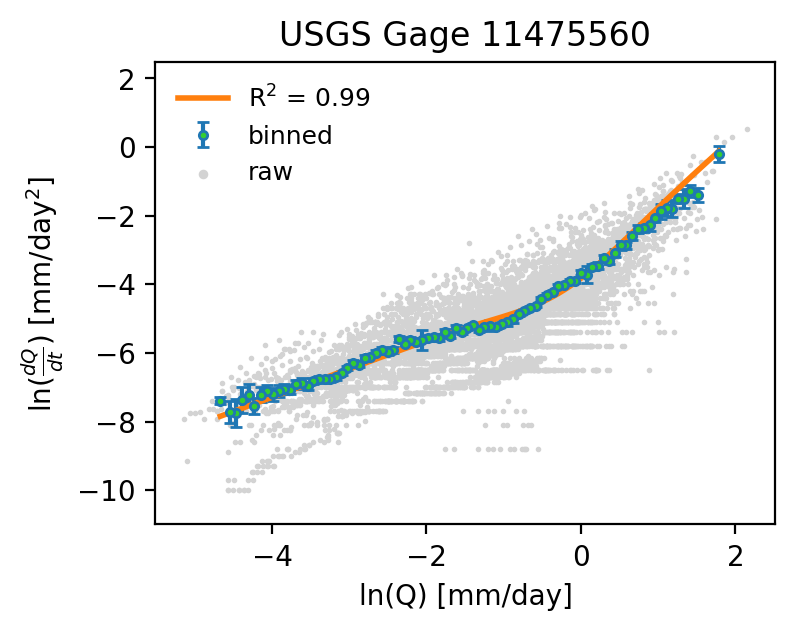

In [ ]:
# Plotting space
fig,ax = plt.subplots(figsize=[4,3])

# Recharge DataFrame
df_recharge = calc_recharge_hourly(df_hourly_flow,ax=ax,title="USGS Gage %s"%gage)
ax.set_ylim(bottom=-11)

# Combine to existing DataFrame
df_cleaned_hourly_flow_rain_deficit_recharge = df_cleaned_hourly_flow_rain_deficit.join(df_recharge)

# Add date and water year columns to final DataFrame
df_hourly_final = df_cleaned_hourly_flow_rain_deficit_recharge.dropna()
df_hourly_final['date'] = df_hourly_final.index
df_hourly_final['wateryear'] = np.where(df_hourly_final.index.month<10, df_hourly_final.index.year, df_hourly_final.index.year+1)

**Plot the storm-event recharge ratio against the deficit at the start of the storm.**  Compare the result of using hourly or daily data.

In [ ]:
# Define functions
def first_rainfall_hourly(df):
  """Find the datetime of the first storm event occuring after the start
  of the precipitation time series.  Return DataFrame after first rainfall.
  ----------
  Parameters
  ----------
  df (:obj:`df`): DataFrame with np.datetime64 index containing precipitation time series (column name = 'ppt') in mm.

  ----------
  Returns
  ----------
  df (:obj:`df`): DataFrame containing data after first rainfall.
  """
  first_rain = df.loc[df['ppt']>=2].index[0]
  lag = pd.Timedelta(hours=6)
  while first_rain <= df.index[0]+lag:
    df = df[first_rain+lag:]
    first_rain = df.loc[df['ppt']>=2].index[0]
  return df[first_rain:]


def first_rainfall(df):
  """Find the datetime of the first storm event occuring after the start
  of the precipitation time series.  Return DataFrame after first rainfall.
  ----------
  Parameters
  ----------
  df (:obj:`df`): DataFrame with np.datetime64 index containing precipitation time series (column name = 'ppt') in mm.

  ----------
  Returns
  ----------
  df (:obj:`df`): DataFrame containing data after first rainfall.
  """
  first_rain = df.loc[df['ppt']>=2].index[0]
  lag = pd.Timedelta(days=2)
  while first_rain <= df.index[0]+lag:
    df = df[first_rain+lag:]
    first_rain = df.loc[df['ppt']>=2].index[0]
  return df[first_rain:]


def hourly_storm_event_analysis(df,gage,to_deficit=False):
  """Hourly storm-event analysis of the interrelation between recharge,
  precipitation, and the root-zone storage deficit.

  Parameters
  ----------
  df: DataFrame containing hourly fluxes
  to_deficit (:obj:`bool`): When True, only plots events up to the deficit being reset
  ----------
  Returns
  ----------
  precip (:obj:`array`): Event precipitation (mm)
  recharge (:obj:`array`): Event recharge (mm)
  deficit (:obj:`array`): Deficit at the start of event (mm)
  length(:obj:`array`): Length of the storm event (days)
  year(:obj:array`): Water year in which the storm event occurred
  """
  # Extract winter hydrology
  winter_months = [10,11,12,1,2,3]
  df_winter = df[df.index.month.isin(winter_months)]

  # Identify water years containing >90% data
  wateryears = np.unique(df_winter.wateryear.values)
  wateryear_length = df.dropna().groupby('wateryear').size()
  complete_wateryears = wateryear_length[wateryear_length>324].index.values

  # Arrays to store storm-event recharge ratio, deficit, and storm volume
  precip = np.array([])
  recharge = np.array([])
  discharge = np.array([])
  deficit = np.array([])
  length = np.array([])
  year = np.array([])

  # Identify storm events
  for wateryear in complete_wateryears:
    # Skip first water year, do not exceed 2020 water year
    if wateryear in [2001,2021]: continue
    # Start water year after first rainfall event occuring after Oct. 1st
    df_wy = first_rainfall_hourly(df_winter[df_winter['wateryear']==wateryear])
    # Storm events up to the deficit being reset
    deficit_reset = df_wy.loc[df_wy.D<=0].index
    if to_deficit==True and len(deficit_reset)!=0: df_wy = df_wy.loc[:deficit_reset[0]]
    # Identify storm periods, excluding the last storm event that occured as the deficit reset
    rainfall = df_wy.loc[df_wy.ppt>0].index
    hours_between_rainfall = np.diff(rainfall)/np.timedelta64(1, 'h')
    groups = np.split(rainfall, np.where(hours_between_rainfall>6.0)[0]+1)
    rainfall_events = np.array([[group[0],group[-1 if len(group)>1 else 0]] for group in groups[:-1]])
    # Remove rainfall events with less than 6 hours between them
    inter_storm = np.array([(rainfall_events[i+1][0]-rainfall_events[i][1])/np.timedelta64(1, 'h') for i in range(len(rainfall_events)-1)])
    rainfall_events = [rainfall_events[0]]+[i for i,j in zip(rainfall_events[1:],inter_storm) if j>=6.0]
    # Calculate fluxes from event
    event_precip = np.array([df_wy.loc[rain_event[0]:rain_event[1]].cumsum().ppt.values[-1] for rain_event in rainfall_events])
    event_recharge = np.array([df_wy.loc[rain_event[0]:rain_event[1]+np.timedelta64(6,'h')].cumsum().rt.values[-1] for rain_event in rainfall_events]) # add day here to account for recharge lag
    event_discharge = np.array([df_wy.loc[rain_event[0]:rain_event[1]].cumsum().rt.values[-1] for rain_event in rainfall_events])
    event_length = np.array([(rain_event[1]-rain_event[0])/np.timedelta64(1,'D') for rain_event in rainfall_events])
    # Identify deficit at start of rainfall periods
    event_deficit = [df_wy.loc[rain_event[0]].D for rain_event in rainfall_events]
    # Append to DataFrame
    precip = np.append(precip,event_precip)
    recharge = np.append(recharge,event_recharge)
    discharge = np.append(recharge,event_discharge)
    deficit = np.append(deficit,event_deficit)
    length = np.append(length,event_length)
    year = np.append(year,[wateryear]*len(event_length))

  return precip, recharge, discharge, deficit, length+1, year


def storm_event_analysis(df_gages,gage,to_deficit=False):
  """Storm-event analysis of the interrelation between recharge, precipitation,
  and the root-zone storage deficit.

  Parameters
  ----------
  df_gages: DataFrame containing combined gage data for all study catchments
  gage: USGS gage ID corresponding to catchment (str)
  to_deficit (:obj:`bool`): When True, only plots events up to the deficit being reset
  ----------
  Returns
  ----------
  precip (:obj:`array`): Event precipitation (mm)
  recharge (:obj:`array`): Event recharge (mm)
  deficit (:obj:`array`): Deficit at the start of event (mm)
  length(:obj:`array`): Length of the storm event (days)
  year(:obj:array`): Water year in which the storm event occurred
  """
  df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']]).dropna()
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index = pd.to_datetime(df_gage.index)

  # Extract winter hydrology
  winter_months = [10,11,12,1,2,3]
  df_winter = df_gage[df_gage.index.month.isin(winter_months)]

  # Identify water years containing >90% data
  wateryears = np.unique(df_winter.wateryear.values)
  wateryear_length = df_gage.dropna().groupby('wateryear').size()
  complete_wateryears = wateryear_length[wateryear_length>324].index.values

  # Arrays to store storm-event recharge ratio, deficit, and storm volume
  precip = np.array([])
  recharge = np.array([])
  discharge = np.array([])
  deficit = np.array([])
  length = np.array([])
  year = np.array([])

  # Identify storm events
  for wateryear in complete_wateryears:
    # Skip first water year, do not exceed 2020 water year
    if wateryear in [2001,2021]: continue
    # Start water year after first rainfall event occuring after Oct. 1st
    df_wy = first_rainfall(df_winter[df_winter['wateryear']==wateryear])
    # Storm events up to the deficit being reset
    deficit_reset = df_wy.loc[df_wy.D<=0].index
    if to_deficit==True and len(deficit_reset)!=0: df_wy = df_wy.loc[:deficit_reset[0]]
    # Identify storm periods, excluding the last storm event that occured as the deficit reset
    rainfall = df_wy.loc[df_wy.ppt>10].index # rainfall events with a total volume greater than 10 cm
    days_between_events = np.diff(rainfall)/np.timedelta64(1, 'D')
    groups = np.split(rainfall, np.where(days_between_events>1.0)[0]+1)
    rainfall_events = [[group[0],group[-1 if len(group)>1 else 0]] for group in groups[:-1]]
    # Check for 2-day gap between rainfall events
    inter_storm = np.array([(rainfall_events[i+1][0] - rainfall_events[i][1])/np.timedelta64(1,'D')-1 for i in range(len(rainfall_events)-1)])
    rainfall_events = [rainfall_events[0]]+[i for i,j in zip(rainfall_events[1:],inter_storm) if j>=2.0]
    # Calculate fluxes from event
    event_precip = np.array([df_wy.loc[rain_event[0]:rain_event[1]].cumsum().ppt.values[-1] for rain_event in rainfall_events])
    event_recharge = np.array([df_wy.loc[rain_event[0]:rain_event[1]+np.timedelta64(1,'D')].cumsum().rt.values[-1] for rain_event in rainfall_events]) # add day here to account for recharge lag
    event_discharge = np.array([df_wy.loc[rain_event[0]:rain_event[1]].cumsum().rt.values[-1] for rain_event in rainfall_events])
    event_length = np.array([(rain_event[1]-rain_event[0])/np.timedelta64(1,'D') for rain_event in rainfall_events])
    # Identify deficit at start of rainfall periods
    event_deficit = [df_wy.loc[rain_event[0]].D for rain_event in rainfall_events]
    # Append to DataFrame
    precip = np.append(precip,event_precip)
    recharge = np.append(recharge,event_recharge)
    discharge = np.append(recharge,event_discharge)
    deficit = np.append(deficit,event_deficit)
    length = np.append(length,event_length)
    year = np.append(year,[wateryear]*len(event_length))

  return precip, recharge, discharge, deficit, length+1, year

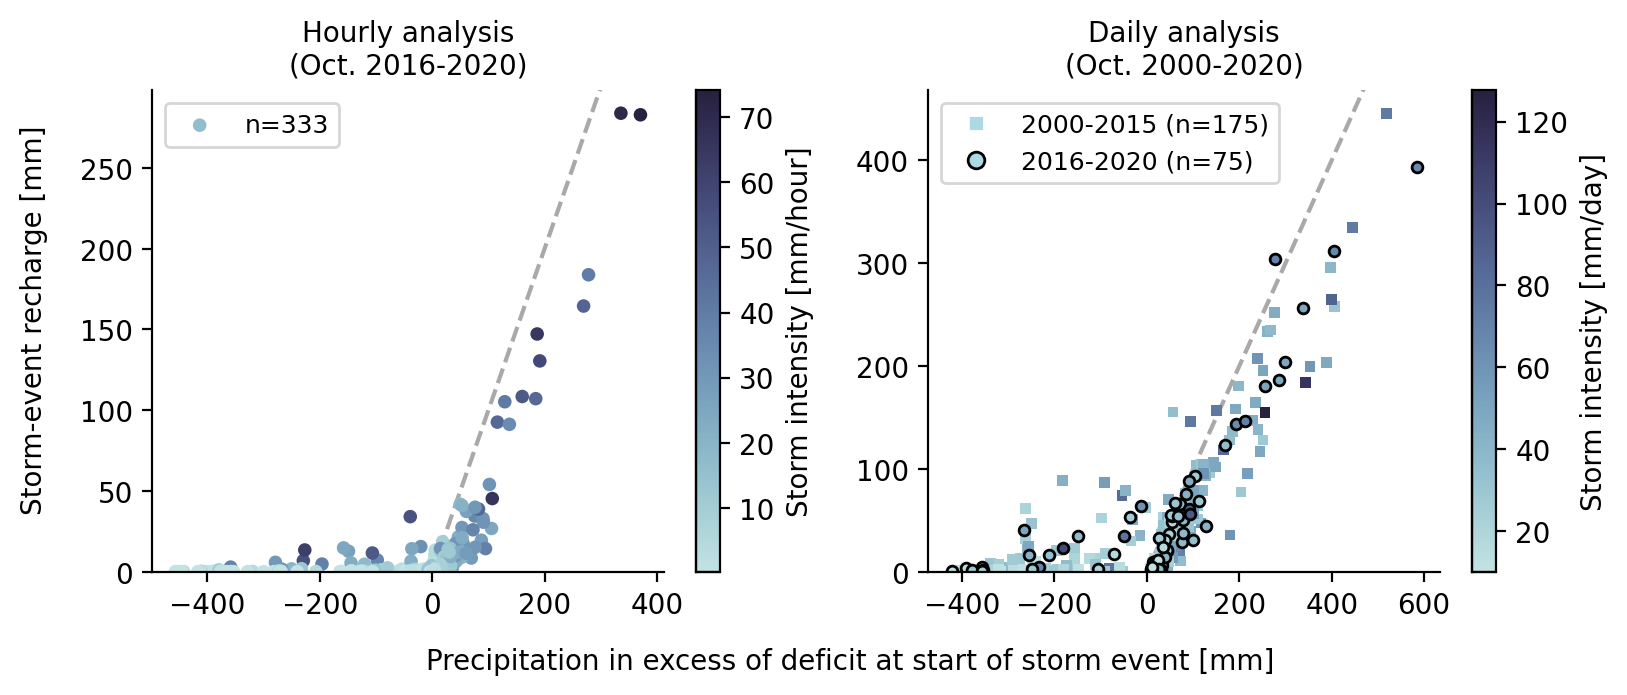

In [ ]:
# Plotting space
fig, axs = plt.subplots(1,2,figsize=(8,3.3))
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True) # for storm volume
gage='11475560'

# Hourly data
ax = axs[0]
precip, recharge, discharge, deficit, length, years = hourly_storm_event_analysis(df_hourly_final,gage)
xdata = precip - deficit
ydata = recharge
colors = precip/length
data = ax.scatter(xdata,ydata,s=15,c=colors,cmap=cmap,label="n=%s"%str(len(xdata)))
axcb = fig.colorbar(data,label="Storm intensity [mm/hour]")
ax.set_ylim(bottom = 0)
ax.legend(loc='upper left', fontsize=9)

# Daily data
ax = axs[1]
precip, recharge, discharge, deficit, length, years = storm_event_analysis(df_gages,gage)
xdata = precip - deficit
ydata = recharge
colors = precip/length
markers=['o' if year>=2016 else 's' for year in years]
edgecolors=['k' if year>=2016 else None for year in years]
for x, y, m, c, ec in zip(xdata,ydata,markers,colors,edgecolors):
  data = ax.scatter(x,y,s=15,marker=m,c=c,ec=ec,cmap=cmap,vmin=min(colors),vmax=max(colors))
axcb = fig.colorbar(data,label="Storm intensity [mm/day]")
ax.set_ylim(bottom = 0)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0],[0],markerfacecolor='lightblue',markeredgecolor='white',marker='s',ls='',label="2000-2015 (n=%s)"%str(len(years[years<2016]))),
                   Line2D([0],[0],markerfacecolor='lightblue',markeredgecolor='k',marker='o',ls='',label="2016-2020 (n=%s)"%str(len(years[years>=2016])))]
ax.legend(handles=legend_elements,loc='upper left', fontsize=9)

# 1:1 line
for ax in axs:
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([xmin,xmax],[xmin,xmax], label="1:1", c='darkgray', ls='--', zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])

# Title
axs[0].set_title("Hourly analysis\n(Oct. 2016-2020)",fontsize=10)
axs[1].set_title("Daily analysis\n(Oct. 2000-2020)",fontsize=10)

# Label handling
fig.text(0.5, -0.03, 'Precipitation in excess of deficit at start of storm event [mm]', ha='center')
fig.text(-0.01, 0.5, 'Storm-event recharge [mm]', va='center', ha='center', rotation='vertical')

# Adjust plot asthetics
fig.tight_layout()
sns.despine()

#**References**
Dralle, D. N., Hahm, W. J., Rempe, D. M., Karst, N. J., Thompson, S. E., & Dietrich, W. E. (2018). Quantification of the seasonal hillslope water storage that does not drive streamflow. Hydrological processes, 32(13), 1978-1992.

Dralle, D. N., Hahm, W. J., & Rempe, D. (2023). Inferring hillslope groundwater recharge ratios from the storage-discharge relation. Geophysical Research Letters, 50 (14).

Kirchner, J. W. (2009). Catchments as simple dynamical systems: Catchment characterization, rainfall‐runoff modeling, and doing hydrology backward. Water Resources Research, 45(2).

Wlostowski, A. N., Molotch, N., Anderson, S. P., Brantley, S. L., Chorover, J., Dralle, D., ... & Harman, C. (2021). Signatures of hydrologic function across the critical zone observatory network. Water Resources Research, 57(3), e2019WR026635.